## Load delhi pm2.5 data 

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 3000)
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

raw_excel_data = pd.read_csv('delhi_cleaned.csv')
df_complex=raw_excel_data.copy()
df_complex.date = pd.to_datetime(df_complex.date,format='%d-%m-%Y %H:%M')
df_complex.set_index("date", inplace=True)
#df= df_complex.asfreq('h')
df=df_complex.copy()

## Decomposed time series

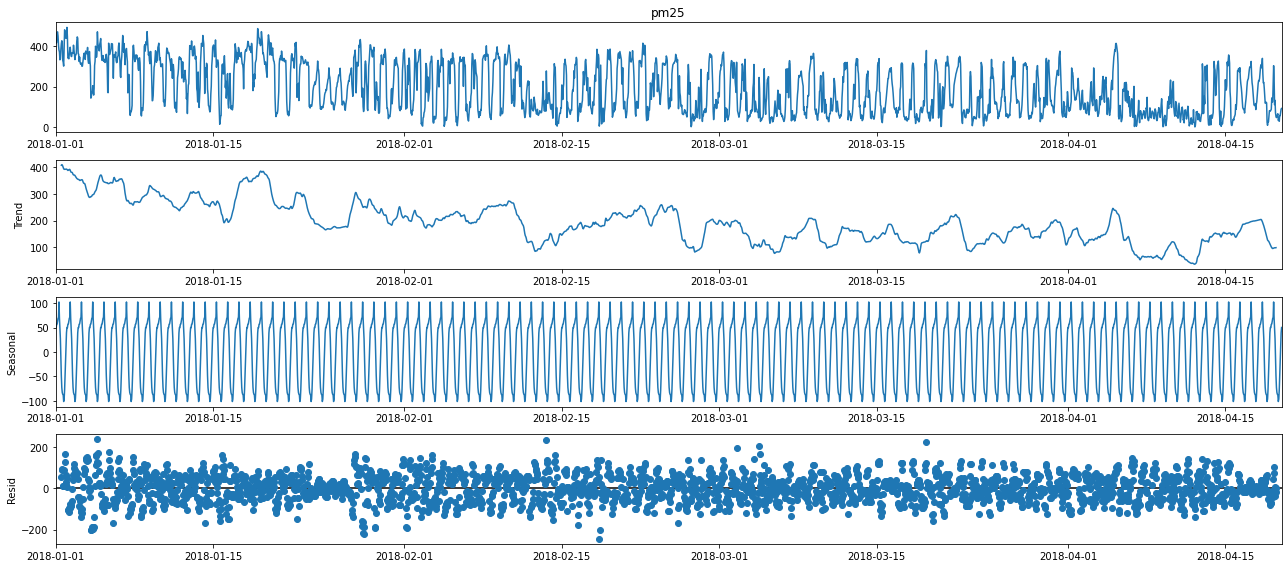

In [2]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df['pm25'], model='additive')
fig = decomposition.plot()
plt.show()

### Split data into test and training data 

In [3]:
size = int(len(df)*0.8)
train_data= df.iloc[:size]
test_data =df.iloc[size:]


In [4]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 24, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, label='Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 2 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

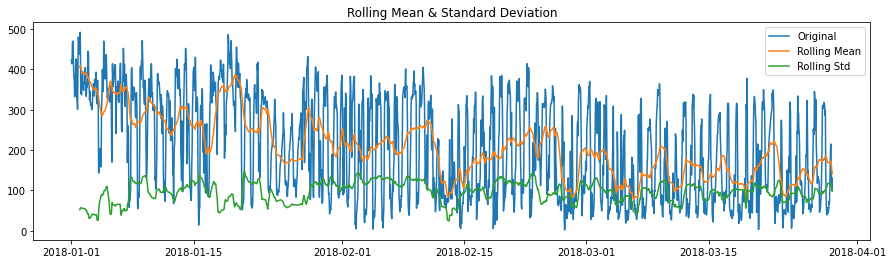

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.296633e+01
p-value                        3.147867e-24
#Lags Used                     1.000000e+00
Number of Observations Used    2.091000e+03
Critical Value (1%)           -3.433481e+00
Critical Value (5%)           -2.862923e+00
Critical Value (10%)          -2.567506e+00
dtype: float64


In [5]:
test_stationarity(train_data['pm25'])


### ACF and PACF of orginal series

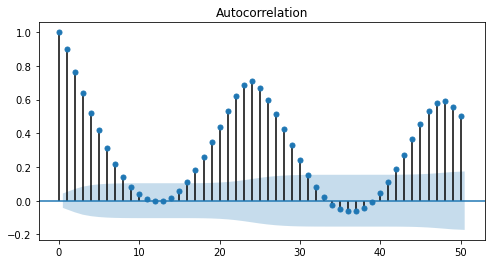

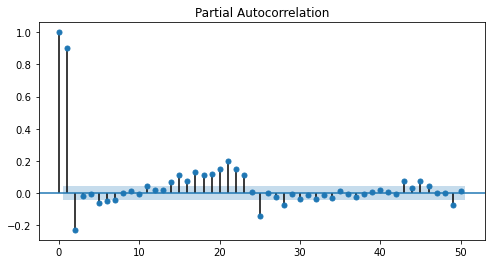

In [6]:
rcParams['figure.figsize'] = 8, 4
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data["pm25"], lags = 50);
plot_pacf(train_data["pm25"], lags = 50);

In [7]:
from statsmodels.tsa.arima_model import ARMA

In [8]:
def evaluate_arma_model(X, arma_order):

    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    predictions = list()
    for t in range(len(test)):
        model = ARMA(history, order=arma_order)

        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [9]:
def evaluate_models(dataset, p_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
            for q in q_values:
                order = (p,q)
                try:
                    rmse = evaluate_arma_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARMA%s RMSE=%.3f' % (best_cfg, best_score))

def parser(x):
    return datetime.strptime('190'+x, '%d-%m-%Y %H:%M')

p_values = [0, 1, 2, 4, 6, 8, 10]
q_values = range(0, 3)
delhi = pd.read_csv('delhi_cleaned.csv', header=0, index_col=0)
delhi['pm25']=delhi['pm25'].astype(str).astype(float)
X=delhi.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
evaluate_models(X, p_values, q_values)

### Model ARMA (6,2)  From Grid search

In [10]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
from math import sqrt
model = ARMA(train_data.pm25.astype(float),order=(6,2))
results = model.fit()

C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Lakshmi K\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


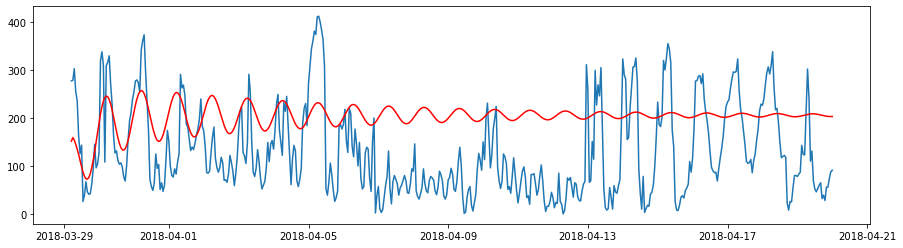

In [11]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=(start), end=(end), dynamic=False, typ='levels').rename('Selected model Predictions')

plt.figure(figsize=(15,4))
plt.plot(test_data['pm25'])
plt.plot(predictions, color='red')
plt.show()

In [12]:

RMSE =  sqrt(mean_squared_error(test_data['pm25'], predictions))

print(RMSE)

115.78621851474593
